In [1]:
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
pd.options.display.max_columns=None

In [2]:
df = pd.read_csv("retailer_sample.csv")
df.columns = (
    df.columns
    .str.lower()
    .str.replace(".", "_")
    .str.replace(" ", "_")
    .str.replace("__", "_")
)

print(df.shape)
df.head(2)

(256853, 11)


,year,month,segment,subsegment,brand,system,province,retailer,sales_units,th_sales_value_usd,th_sales_value_ars
0,2017,January,A,01,BRAND-1,Old,BUENOS AIRES,F,912.645,483.412463,7702.772260
1,2017,February,A,01,BRAND-1,Old,BUENOS AIRES,F,786.420,413.161071,6511.058545


In [3]:
months = {
    "January": "01", "February": "02",
    "March": "03", "April": "04",
    "May": "05", "June": "06",
    "July": "07", "August": "08",
    "September": "09", "October": "10",
    "November": "11", "December": "12",
}
df["month_num"] = df["month"].replace(months)
df["year"] = df["year"].astype(str)

df["date"] = df["year"] + "-" + df["month_num"]
df["date"] = pd.to_datetime(df["date"], format="%Y-%m")

### Ventas totales diarias por retailer

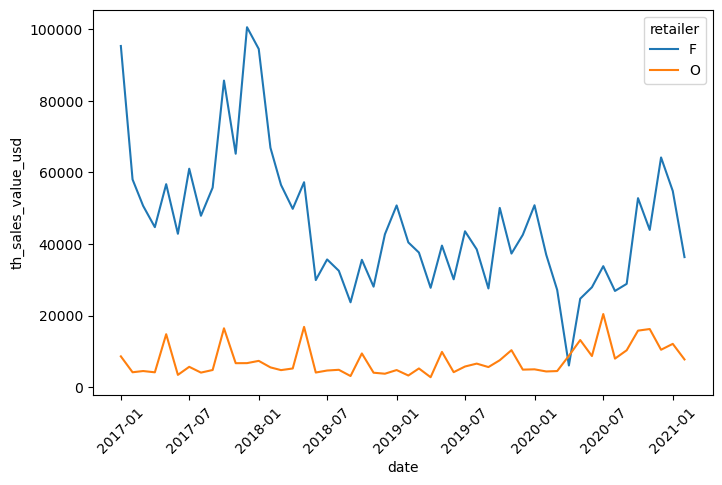

In [4]:
fig =  plt.subplots(figsize=(8, 5))
sns.lineplot(
    x="date", 
    y="th_sales_value_usd", 
    hue="retailer",
    data=df,
    estimator="sum",
    ci=None
)
_ = plt.xticks(rotation=45)

In [8]:
aux = (
    df
    .groupby(["date", "retailer"])
    .agg(
        tot_sales_value_usd = ("th_sales_value_usd", "sum")
    )
    .reset_index()
)

In [12]:
print(6115.217660 / 27205.009571 -1)
print(8818.286087 / 4551.562614 -1)
aux.query("date>'2020-02-01'").head(5)

-0.7752172207827965
0.9374194831190781


,date,retailer,tot_sales_value_usd
76,2020-03-01,F,27205.009571
77,2020-03-01,O,4551.562614
78,2020-04-01,F,6115.217660
79,2020-04-01,O,8818.286087
80,2020-05-01,F,24751.635638


### Participacion de las ventas de los segmentos por anio por retailer

In [5]:
date_str = "year"
segment_tot_date = (
    df
    .groupby([date_str, "retailer", "segment"])
    .agg({"th_sales_value_usd": "sum"})
    .reset_index()
)
tot_retailer_date = (
    segment_tot_date
    .groupby([date_str, "retailer"])
    .agg(
        tot_sales_value_usd = ("th_sales_value_usd", "sum")
    )
    .reset_index()
)
segment_tot_date = (
    segment_tot_date
    .merge(
        tot_retailer_date,
        on=[date_str, "retailer"]
    )
)
segment_tot_date["share_segment"] = (
    segment_tot_date["th_sales_value_usd"]/segment_tot_date["tot_sales_value_usd"]
)

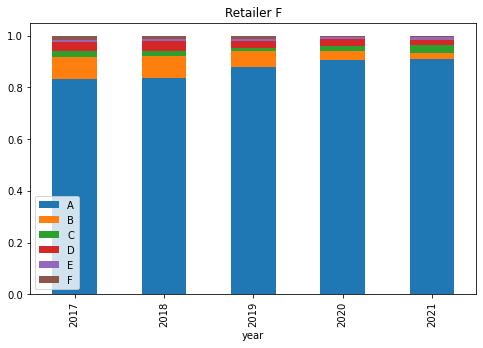

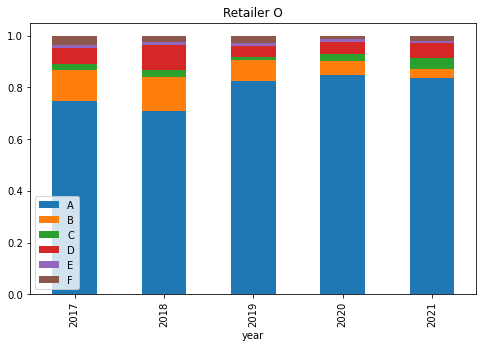

In [ ]:
for retailer in sorted(segment_tot_date["retailer"].unique()):
    data_plot = (
        segment_tot_date
        .query("retailer==@retailer")
        .drop(columns=["retailer", "th_sales_value_usd", "tot_sales_value_usd"])
        .pivot_table(index=date_str, columns=["segment"])
    )
    data_plot.columns = [x[1] for x in data_plot.columns]
    data_plot.plot(kind='bar', stacked=True, figsize=(8, 5))
    plt.title(f"Retailer {retailer}")

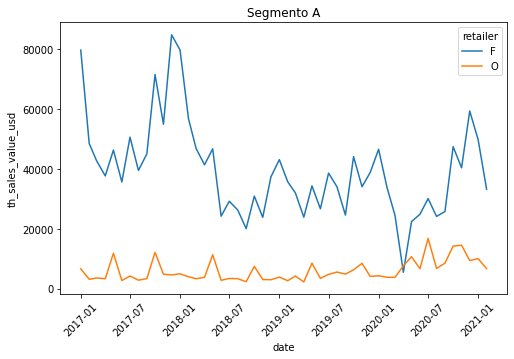

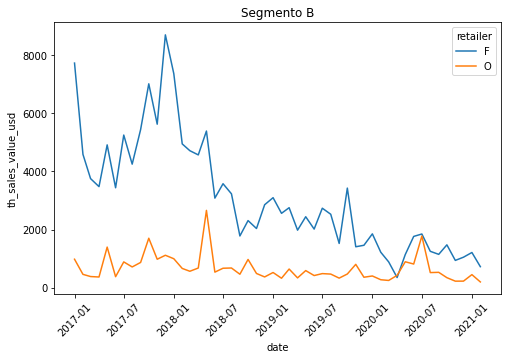

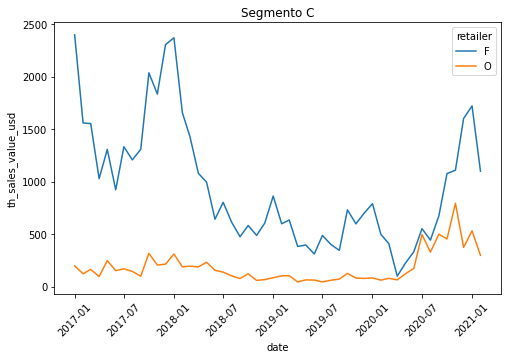

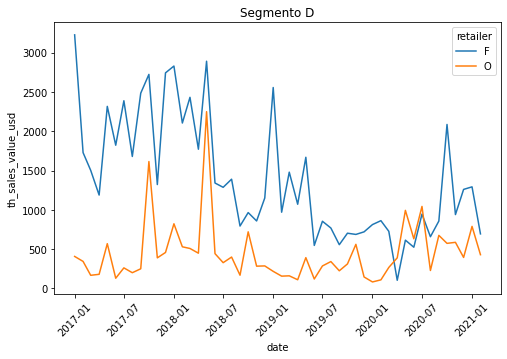

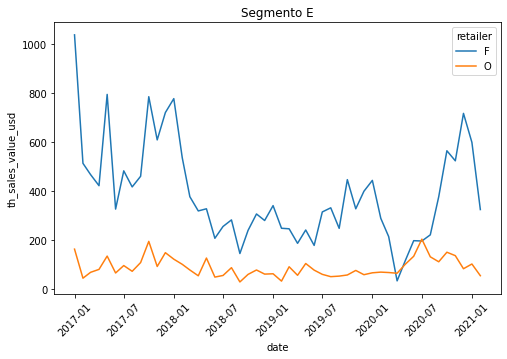

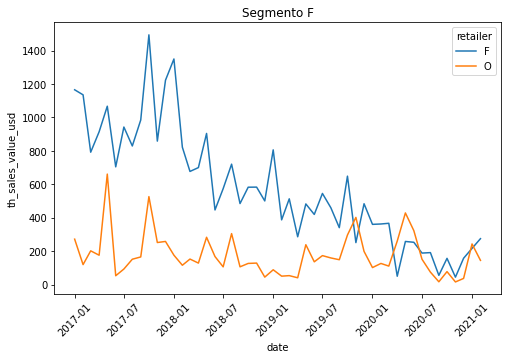

In [ ]:
segment_tot_date = (
    df
    .groupby(["date", "retailer", "segment"])
    .agg({"th_sales_value_usd": "sum"})
    .reset_index()
)
for segment in sorted(segment_tot_date["segment"].unique()):
    fig =  plt.subplots(figsize=(8, 5))
    sns.lineplot(
        x="date", 
        y="th_sales_value_usd", 
        hue="retailer",
        data=segment_tot_date.query("segment==@segment"),
        estimator="sum",
        ci=None
    )
    _ = plt.xticks(rotation=45)
    _ = plt.title(f"Segmento {segment}")

In [ ]:
# pandemia

In [34]:
df["comb"] = (df["segment"]+"-"+df["subsegment"]+"-"+df["brand"])
# df["comb"] = df["subsegment"]+"-"+df["brand"]
# df.groupby("retailer").agg({"comb": "nunique"})

In [35]:
df.head(2)

,year,month,segment,subsegment,brand,system,province,retailer,sales_units,th_sales_value_usd,th_sales_value_ars,month_num,date,comb
0,2017,January,A,01,BRAND-1,Old,BUENOS AIRES,F,912.645,483.412463,7702.772260,01,2017-01-01,A-01-BRAND-1
1,2017,February,A,01,BRAND-1,Old,BUENOS AIRES,F,786.420,413.161071,6511.058545,02,2017-02-01,A-01-BRAND-1


In [36]:
df_comb = (
    df
    .groupby(["date", "retailer", "comb"])
    .agg({"th_sales_value_usd": "sum"})
)
print(df_comb.shape)
df_comb.head(2)

(12042, 1)


th_sales_value_usd
date       retailer comb                             
2017-01-01 F        A-01-BRAND-1          4673.414628
                    A-01-BRAND-10          488.557773

In [37]:
# gini mensual por retailer con respecto a las ventas de cada combinacion
import quantecon as qe

df_gini = (
    df_comb
    .groupby(["date", "retailer"])
    .agg(
        gini_sales = ("th_sales_value_usd", lambda x: qe.gini_coefficient(x.values))
    )
    .reset_index()
    
)

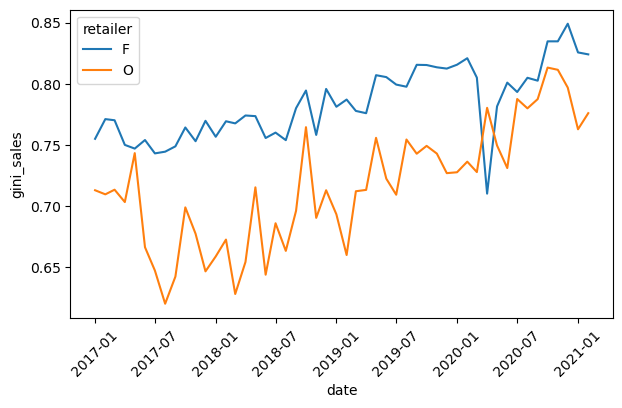

In [39]:
fig =  plt.subplots(figsize=(7, 4))
sns.lineplot(
    x="date", 
    y="gini_sales", 
    hue="retailer",
    data=df_gini,
    ci=None
)
_ = plt.xticks(rotation=45)

df_agg_province = (
    df
    .groupby(["year", "retailer", "province"])
    .agg({"th_sales_value_usd": "sum"})
    .reset_index()
    .merge(
        tot_retailer_date, on=["year", "retailer"]
    )
)
df_agg_province["share_province"] = df_agg_province["th_sales_value_usd"] /df_agg_province["tot_sales_value_usd"]

df_agg_province = (
    df_agg_province
    .sort_values(["year", "retailer", "share_province"], ascending=[True, True, False])
)
df_agg_province["share_cum"] = df_agg_province.groupby(["year", "retailer"])["share_province"].cumsum().values

In [64]:
#df_agg_province.query("retailer=='O'")

In [63]:
#df_agg_province[(df_agg_province["share_cum"]<=0.8)]#["province"].value_counts()

---